# Preparacion de los datos

## Generar data frame

*Primeramente, cargamos los conjuntos de datos utilizando la función pandas `read_csv()`. Dado que los datos contienen caracteres especiales en español, así que tuvimos que especificar la codificación correcta `encoding='latin1'` para garantizar que estos caracteres se lean correctamente.*


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Cargamos los datos
INEGI = pd.read_csv('datosINEGI.csv')
CONEVAL = pd.read_csv('datosCONEVAL.csv', encoding='latin1')

/var/folders/nq/zht86vzj6n5g3py55h5xd7xr0000gn/T/ipykernel_71039/1596713616.py:7: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  INEGI = pd.read_csv('datosINEGI.csv')


*El dataset incluye varios niveles de granularidad de los datos, entonces para centrarnos en los datos aggregados a nivel municipal, filtramos las filas en las que la columna `NOM_LOC` (Nombre Local) es igual a "Total del Municipio".Así que nos asegura que nuestro análisis se base en datos municipales completos y no en localidades más granulares.*

In [11]:
# # Filter rows where NOM_LOC == "Total del Municipio"
INEGI_total = INEGI[INEGI['NOM_LOC'] == "Total del Municipio"]

*En los datasets en los que varias regiones comparten los mismos códigos de municipio, nos es esencial crear un identificador único para cada municipio para evitar ambigüedades. Lo cual conseguimos combinando las columna `ENTIDAD` (Código de Estado) y `MUN` (Código de Municipio) columnas. Para esto, multiplicamos `ENTIDAD` por 1000 y luego añadimos `MUN` y nos funciona ya que cada municipio, incluso los que tienen el mismo `MUN` en distintos estados, tengan un identificador distinto.*

In [12]:
# # Make MUN in INEGI_total be ENTIDAD * 1000 + MUN
INEGI_total['MUN'] = INEGI_total['ENTIDAD'] * 1000 + INEGI_total['MUN']

*Para nuestro análisis, nos centramos en columnas específicas dentro del dataset del CONEVAL, puesto que*

*`clave_municipio` Es análogo al código de municipio del dataset del INEGI.*

*`pobreza_m` Porcentaje de la población en situación de pobreza moderada*

*`ic_asalud` Porcentaje de la población con carencia por acceso a los servicios de salud*

In [13]:
# # Drop columns that are not needed from CONEVAL(only columns needed are 'clave_municipio', 'pobreza_m', "ic_asalud")
CONEVAL = CONEVAL[['clave_municipio', 'pobreza_m', 'ic_asalud']]

*Realizamos una operación de fusión de datasets con información tanto del INEGI como del CONEVAL, la cual nos permite combinar datos relacionados basándonos en una clave común. En este caso, fusionamos la columna `MUN` del dataset del INEGI y la columna `clave_municipio` del dataset del CONEVAL. Así como es importante notar que estas columnas, aunque representan la misma entidad, tienen nombres diferentes. Para esot la funcion `pd.merge()` de pandas nos facilita esta tarea al permitirnos especificar las columnas a unir mediante parámetros `left_on` y `right_on`. Por ende tras la fusión, la columna `clave_municipio` resulta redundante, ya que su información está ahora integrada en el dataset, por lo que la eliminamos para mantener un datast limpio.*

In [14]:
# # MERGE INEGI_total and CONEVAL from MUN and clave_municipio
merged = pd.merge(INEGI_total, CONEVAL, left_on='MUN', right_on='clave_municipio')

# # Drop clave_municipio
merged = merged.drop(columns=['clave_municipio'])

*Eliminamos las columnas que no son esenciales para nuestro análisis, en concreto, eliminamos las nueve primeras columnas, que pueden contener metadatos u otra información extraña, así que este paso reduce el desorden de los datos y centra nuestro dataset en las variables de interés.*

In [15]:
# #Drop columns that are not needed from merged, first 9 columns are not needed
merged = merged.drop(columns=merged.columns[0:9])

# # drop TAMLOC column
merged = merged.drop(columns='TAMLOC')

*Aseguramos de que todos los datos están en formato numérico para poder realizar cálculos y análisis sin problemas. De modo que utilizamos la función `pd.to_numeric()` para convertir los datos aplicables a tipos numéricos, al mismo tiempo que puede coaccionar valores no numéricos a `NaN` (Not a Number).*

In [16]:
# #fix data types, all numeric
merged = merged.apply(pd.to_numeric, errors='coerce')

*Tras el procesamiento, guardamos el dataset depurado como `merged.csv`, para que los datos procesados se almacenen para su uso futuro, preservando los resultados de nuestros esfuerzos de preparación de datos. Además, al mostrar la forma del dataset (es decir, el número de filas y columnas), obtenemos una rápida visión general de sus dimensiones, lo que puede ser útil para comprender el alcance de nuestros datos.*

In [17]:
# # Save the merged data
merged.to_csv('merged.csv', index=False)

merged.shape, CONEVAL.shape, INEGI_total.shape

((2469, 278), (2469, 3), (2469, 286))

## Preparación y escalamiento de la base de datos.
### Se eliminan filas donde existan valores nulos, y se revisa que no queden de estos.
### Se hace un escalamiento de los datos en un rango de 0 a 1, para su uso en modelos para feturing selection.
### Se separan los datos para entrenar los modelos de selección de variables.


*Después de fusionar los datasets, nos interesa preparar los datos para el análisis tratando los valores que faltan, escalando las características y definiendo las variables de entrada y de destino.*

*Los datos que faltan pueden dar lugar a análisis sesgados y reducir la potencia estadística de los modelos. Por lo tanto, ocupamos elimanar a las filas con valores perdidos.*

In [18]:
data = pd.read_csv('merged.csv')
data = data.dropna()
print(data.shape)
print(data.isna().sum())

data.iloc[:, :-2] = data.iloc[:, :-2].div(data['POBTOT'], axis=0)

data.head()

(2466, 278)
POBTOT         0
POBFEM         0
POBMAS         0
P_0A2          0
P_0A2_F        0
              ..
VPH_SINLTC     0
VPH_SINCINT    0
VPH_SINTIC     0
pobreza_m      0
ic_asalud      0
Length: 278, dtype: int64


/var/folders/nq/zht86vzj6n5g3py55h5xd7xr0000gn/T/ipykernel_71039/3359892633.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
2464    1.0
2465    1.0
2466    1.0
2467    1.0
2468    1.0
Name: POBTOT, Length: 2466, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.iloc[:, :-2] = data.iloc[:, :-2].div(data['POBTOT'], axis=0)
/var/folders/nq/zht86vzj6n5g3py55h5xd7xr0000gn/T/ipykernel_71039/3359892633.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0       0.513090
1       0.509838
2       0.509648
3       0.512235
4       0.505738
          ...   
2464    0.511262
2465    0.505989
2466    0.518926
2467    0.509215
2468    0.512107
Name: POBFEM, Length: 2466, dtype: float64' has dtype incompatible with int64, ple

,POBTOT,POBFEM,POBMAS,P_0A2,P_0A2_F,P_0A2_M,P_3YMAS,P_3YMAS_F,P_3YMAS_M,P_5YMAS,...,VPH_INTER,VPH_STVP,VPH_SPMVPI,VPH_CVJ,VPH_SINRTV,VPH_SINLTC,VPH_SINCINT,VPH_SINTIC,pobreza_m,ic_asalud
0,1.0,0.513090,0.486910,0.046757,0.023070,0.023687,0.952259,0.489527,0.462732,0.918021,...,0.188220,0.137293,0.085302,0.059148,0.003476,0.007685,0.078217,0.000770,21.7,20.0
1,1.0,0.509838,0.490162,0.061510,0.031803,0.029707,0.938102,0.477841,0.460261,0.894423,...,0.087822,0.075326,0.011565,0.010789,0.007315,0.028077,0.139825,0.003434,36.0,16.5
2,1.0,0.509648,0.490352,0.054232,0.027142,0.027090,0.945167,0.482197,0.462970,0.904567,...,0.112498,0.081528,0.023725,0.023210,0.007605,0.015519,0.138386,0.002369,41.3,21.0
3,1.0,0.512235,0.487765,0.060706,0.031706,0.029000,0.939294,0.480529,0.458765,0.897294,...,0.102412,0.097882,0.013118,0.011235,0.008176,0.024353,0.112471,0.002941,33.7,17.6
4,1.0,0.505738,0.494262,0.053452,0.026014,0.027438,0.945478,0.479185,0.466293,0.904887,...,0.153315,0.103772,0.071547,0.050658,0.003694,0.008851,0.088102,0.001139,23.1,21.1


*Como en el aprendizaje supervisado, se distringue entre características de entrada (X) y variables objetivo (Y).*

*`X` Son los predictores utilizados por el modelo para hacer predicciones, en nuestro caso, se seleccionan como características todas las columnas excepto las dos últimas.*

*`Y` Son los resultados que el modelo pretende predecir.*
*   *Y_pobreza Representa el indicador de pobreza moderada.*
*   *Y_salud Representa el indicador de acceso a la sanidad*


In [19]:
array = data.values

X = array[:, :-2]
Y_pobreza = array[:, -2]
Y_salud = array[:, -1]

# FEATURE SELECTION DE POBREZA MODERADA

*Random Forest es un método de aprendizaje por conjuntos que construyee múltiples árboles de decisión durante el entrenamiento y genera la predicción media de los árboles individuales. Lo cual resulta especialmente útil para evaluar la importancia de las características debido a su capacidad inherente para evaluar la contribución de cada característica a la hora de realizar predicciones.*

In [20]:
# RandomForest pobreza
names = np.array(data.columns[:-2])

Empleamos `RandomForestRegressor` para predecir la variable objetivo `pobreza_m`. Justo este modelo aprende patrones en los datos considerando varios subconjuntos de características y observaciones, asegurando así la robustez frente al sobreajuste.

In [21]:
from sklearn.ensemble import RandomForestRegressor

*Para identificar y retener sólo las caracterísitcas más significativas, utilizamos `SelectFromModel`. Por defecto, retiene las características cuya importancia es mayor que la importancia media de todas las características.*

In [22]:
from sklearn.feature_selection import SelectFromModel

*Tras ajustar el modelo, se asigna a cada característica una puntuación de importancia, que refleja su contribución a la predicción. Por lo que, la clasificación de estas características en orden descendente de importancia proporciona información sobre qué características son las más influyentes*

Características seleccionadas y ordenadas por importancia: ['VPH_HMICRO' 'VPH_CEL' 'VPH_PISODT' 'PDER_IMSS' 'PDER_SEGP' 'VPH_PC'
 'VPH_AGUAFV' 'VPH_REFRI' 'VPH_SPMVPI' 'PDER_ISTE' 'VPH_3YMASC'
 'VPH_AUTOM' 'VPH_1CUART' 'P15YM_AN_F' 'VPH_NODREN' 'VPH_PISOTI' 'PSINDER'
 'VPH_2YMASD' 'PDER_SS' 'VPH_NDEAED' 'P15YM_SE_F' 'P15PRI_CO' 'P15PRI_COF'
 'P15YM_SE_M' 'P15PRI_COM' 'VPH_CVJ']


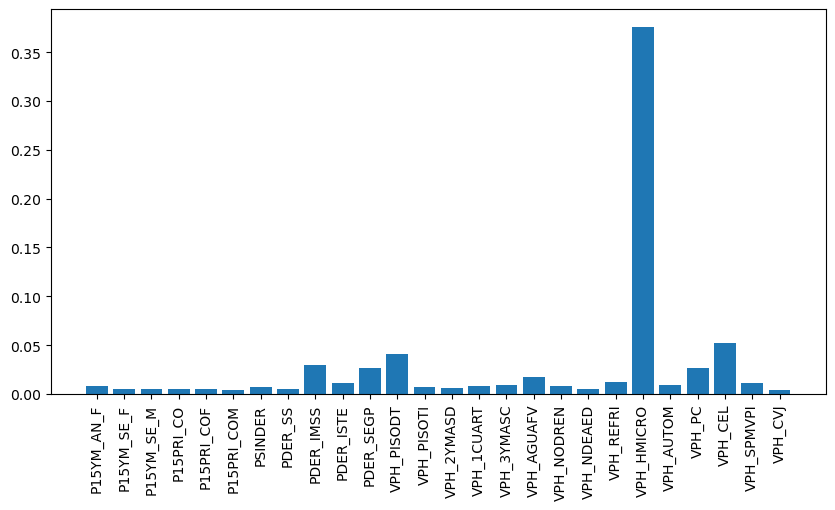

In [23]:
rf = RandomForestRegressor(n_estimators=150, random_state=42).fit(X, Y_pobreza)
selector = SelectFromModel(estimator=rf, threshold='mean', prefit=True)

selected = selector.get_support()
s_features = names[selected]
selected_importances = rf.feature_importances_[selected]
sorted_s_features = s_features[np.argsort(selected_importances)[::-1]]

print("Características seleccionadas y ordenadas por importancia:", sorted_s_features)

# Plot the feature scores per feature
plt.figure(figsize=(10, 5))
plt.bar(s_features, selected_importances)
plt.xticks(rotation=90)
plt.show()

*El `ExtraTreesRegressor` es otro método de conjunto que agrega los resultados de múltiples árboles de decisión descorrelacionados para producir una predicción. A diferencia de los bosques aleatorios, que utilizan el muestreo bootstrap y buscan la división óptima en cada nodo, los árboles adicionales seleccionan los puntos de corte aleatoriamente y utilizan todo el conjunto de datos para el entrenamiento. Por lo cual esta aleatoriedad puede reducir la varianza y la eficiencia computacional que nos beneficia.*

Características seleccionadas y ordenadas por importancia: ['VPH_HMICRO' 'VPH_AUTOM' 'PDER_IMSS' 'VPH_CEL' 'VPH_LAVAD' 'PDER_SEGP'
 'VPH_REFRI' 'VPH_CVJ' 'VPH_PC' 'VPH_SPMVPI' 'VPH_2YMASD' 'VPH_TV'
 'VPH_PISODT' 'VPH_3YMASC' 'PDER_ISTE' 'P15YM_AN_F' 'VPH_C_SERV' 'PSINDER'
 'P15YM_SE_F' 'PDER_SS' 'P15PRI_CO' 'VPH_1CUART' 'VPH_DRENAJ' 'VPH_NODREN'
 'P3HLINHE_M' 'P15PRI_COF' 'VPH_DSADMA' 'VPH_PISOTI' 'P15YM_SE'
 'P18YM_PB_M' 'VPH_NDACMM' 'VPH_STVP' 'VPH_INTER' 'P15PRI_COM'
 'VPH_AGUAFV' 'VPH_SINLTC' 'P15YM_AN' 'VPH_TINACO']


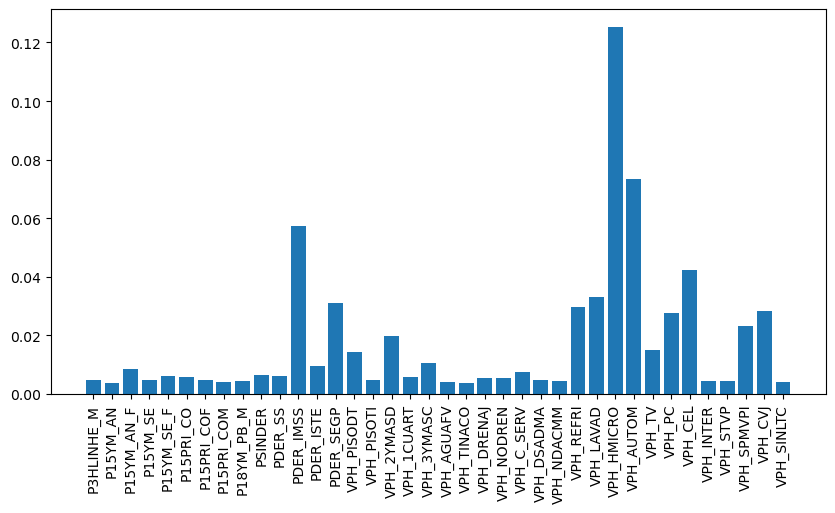

In [24]:
from sklearn.ensemble import ExtraTreesRegressor

et = ExtraTreesRegressor(n_estimators=150, random_state=42).fit(X, Y_pobreza)
selector = SelectFromModel(estimator=et, threshold='mean', prefit=True)

selected = selector.get_support()
s_features = names[selected]
selected_importances = et.feature_importances_[selected]
sorted_s_features = s_features[np.argsort(selected_importances)[::-1]]

print("Características seleccionadas y ordenadas por importancia:", sorted_s_features)
# Plot the feature scores per feature
plt.figure(figsize=(10, 5))
plt.bar(s_features, selected_importances)
plt.xticks(rotation=90)
plt.show()

*XGBoost (Extreme Gradient Boosting) es una implementación potente y eficiente de los algoritmos de refuerzo de gradiente. Asi mismo, está diseñado para ofrecer velocidad y rendimiento, lo que a menudo se traduce en una precisión predictiva superior.*

Características seleccionadas y ordenadas por importancia: ['VPH_HMICRO' 'VPH_CEL' 'VPH_PISODT' 'VPH_PC' 'VPH_REFRI' 'VPH_3YMASC'
 'VPH_AUTOM' 'PDER_SEGP' 'VPH_DRENAJ' 'P15YM_AN_F' 'PDER_IMSS'
 'VPH_NODREN' 'P_15YMAS_M' 'VPH_AGUAFV' 'P15PRI_COF' 'P3HLI_HE'
 'P18YM_PB_M' 'P5_HLI_NHE' 'P3HLINHE_M' 'VPH_NDEAED' 'P15PRI_CO'
 'P8A14AN_F' 'VPH_C_SERV' 'PHOGJEF_M' 'VPH_RADIO' 'P15YM_AN' 'P15SEC_CO'
 'VPH_NDACMM' 'VPH_1CUART' 'POCUPADA_M' 'VPH_PISOTI' 'TVIVHAB' 'POB0_14'
 'PDER_ISTE' 'PSINDER' 'P_70A74_M' 'VPH_SINRTV' 'P15YM_SE_M' 'VPH_CVJ'
 'P_5YMAS_M' 'VPH_LAVAD' 'PNACOE_M' 'VPH_2YMASD' 'P_12YMAS_F' 'P15SEC_COM'
 'P3HLI_HE_M' 'PAFIL_IPRIV' 'VPH_AEASP' 'PRES2015_F' 'P_10A14_F']


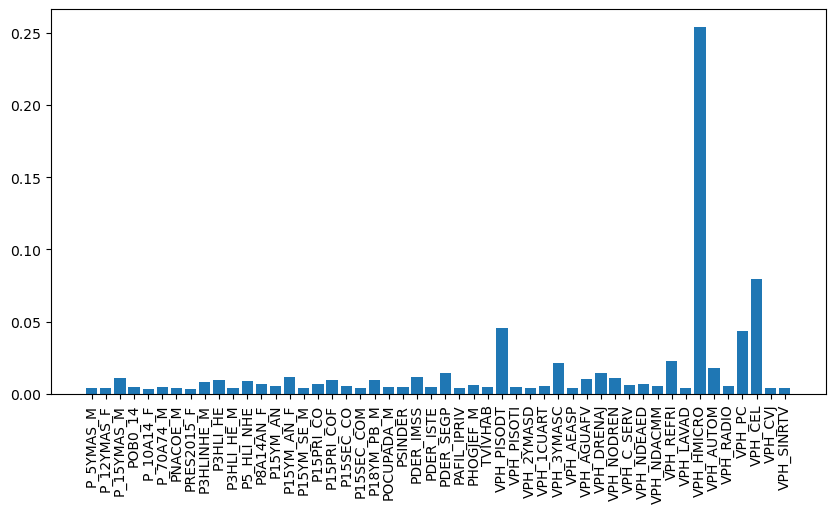

In [25]:
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=50).fit(X, Y_pobreza)
selector = SelectFromModel(estimator=xgb, threshold='mean', prefit=True)

selected = selector.get_support()
s_features = names[selected]
selected_importances = xgb.feature_importances_[selected]
sorted_s_features = s_features[np.argsort(selected_importances)[::-1]]

print("Características seleccionadas y ordenadas por importancia:", sorted_s_features)
# Plot the feature scores per feature
plt.figure(figsize=(10, 5))
plt.bar(s_features, selected_importances)
plt.xticks(rotation=90)
plt.show()

*Aquí tenemos otro enfoque, ya que calculamos la correlación estadística entre cada característica y la variable objetivo `pobreza_m`. Las características con los coeficientes de correlación más altos (ya sean positivos o negativos) se consideran más relevantes. También, la selección de las 10 características principales basada en estas correlaciones ayuda a centrarse en las variables con mayor impacto, mejorando potencialmente el rendimiento y la interpretabilidad del modelo.*

Características seleccionadas y ordenadas por importancia: ['VPH_HMICRO' 'VPH_PC' 'VPH_CVJ' 'PDER_IMSS' 'VPH_AUTOM' 'VPH_SPMVPI'
 'PDER_SEGP' 'VPH_INTER' 'VPH_LAVAD' 'VPH_NDACMM']


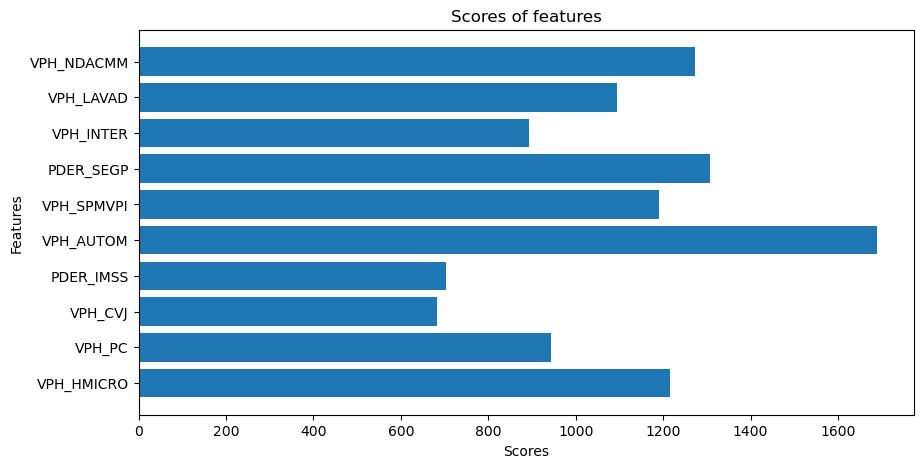

In [26]:
# SelectKbest pobreza

from sklearn.feature_selection import SelectKBest, f_regression

skb = SelectKBest(score_func=f_regression, k=10).fit(X, Y_pobreza)
selected = skb.get_support()
selected_features = names[selected]
selected_scores = skb.scores_[selected]
selected_features = selected_features[np.argsort(selected_scores)[::-1]]

print("Características seleccionadas y ordenadas por importancia:", selected_features)
plt.figure(figsize=(10, 5))
plt.barh(selected_features, selected_scores)
plt.xlabel('Scores')
plt.ylabel('Features')
plt.title('Scores of features')
plt.show()

## FEATURE SELECTION DE IC_SALUD

*Se entrena un `RandomForestRegressor` utilizando `ic_asalud` como variable objetivo, así como el `SelectFromModel` se utiliza para retener sólo las características más importantes, filtrando aquellas con puntuaciones de importancia por debajo de la media. Ayudandonos a comprender qué factores socioeconómicos contribuyen más al acceso a la sanidad y funciona bien con conjuntos de datos que contienen datos numéricos y categóricos.*

Características seleccionadas y ordenadas por importancia: ['PSINDER' 'PDER_SS' 'REL_H_M']


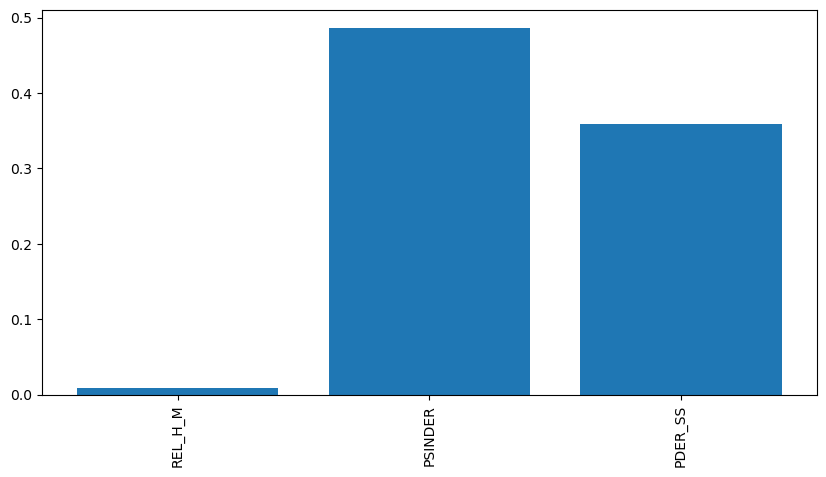

In [27]:
# RandomForest ICSS

rf = RandomForestRegressor(n_estimators=150, random_state=42).fit(X, Y_salud)
selector = SelectFromModel(estimator=rf, threshold='mean', prefit=True)

selected = selector.get_support()
s_features = names[selected]
selected_importances = rf.feature_importances_[selected]
sorted_s_features = s_features[np.argsort(selected_importances)[::-1]]

print("Características seleccionadas y ordenadas por importancia:", sorted_s_features)
# Plot the feature scores per feature
plt.figure(figsize=(10, 5))
plt.bar(s_features, selected_importances)
plt.xticks(rotation=90)
plt.show()

*El modelo `ExtraTreesRegressor` se entrena con `ic_asalud` como objetivo.Así mismo, se extraen las puntuaciones de importancia de las característica y se clasifican las características y se eliminan las menos importantes.
Nos es útil porque funciona bien cuando las características del conjunto de datos tienen una alta correlació y ayuda a comprender la importancia de las relaciones no lineales en los datos.*

Características seleccionadas y ordenadas por importancia: ['PSINDER' 'PDER_SS' 'PDER_SEGP' 'PEA' 'POCUPADA' 'POCUPADA_F']


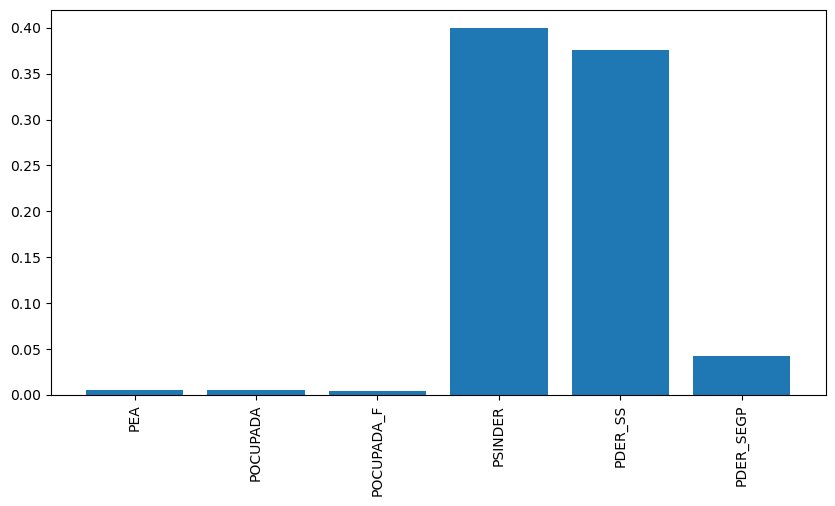

In [28]:
from sklearn.ensemble import ExtraTreesRegressor

et = ExtraTreesRegressor(n_estimators=150, random_state=42).fit(X, Y_salud)
selector = SelectFromModel(estimator=et, threshold='mean', prefit=True)

selected = selector.get_support()
s_features = names[selected]
selected_importances = et.feature_importances_[selected]
sorted_s_features = s_features[np.argsort(selected_importances)[::-1]]

print("Características seleccionadas y ordenadas por importancia:", sorted_s_features)
# Plot the feature scores per feature
plt.figure(figsize=(10, 5)) 
plt.bar(s_features, selected_importances)
plt.xticks(rotation=90)
plt.show()

*Nuevamente XGBoost es un potente algoritmo de aprendizaje automático que construye árboles secuencialmente, corrigiendo los errores de los árboles anteriores.*
*Destacando las las características en función de*
*   *Ganancia (cuánto mejora una característica la precisión del modelo cuando se utiliza como división).*
*   *Cobertura (frecuencia con la que se utiliza una característica para dividir los árboles).*
*   *Peso (el número de veces que se utiliza una característica en las divisiones).*


Características seleccionadas y ordenadas por importancia: ['PSINDER' 'PDER_SS' 'GRAPROES_F' 'P15SEC_CO' 'PSIND_LIM' 'P15SEC_COM'
 'VPH_1CUART' 'GRAPROES_M' 'REL_H_M' 'POB65_MAS' 'P3HLINHE_M' 'POTRAS_REL'
 'P12A14NOAM' 'TVIVPAR' 'PE_INAC_F' 'P15YM_AN_F' 'P18A24A_M' 'PCDISC_MEN'
 'P3A5_NOA_M' 'P15YM_AN' 'PCDISC_LENG' 'PROM_OCUP' 'PRES2015_M' 'POB_AFRO'
 'PCLIM_VIS' 'PROM_HNV' 'P15SEC_IN' 'VPH_RADIO' 'VPH_PISOTI' 'P3HLINHE_F'
 'VPH_LAVAD' 'PAFIL_IPRIV' 'P_85YMAS_M']


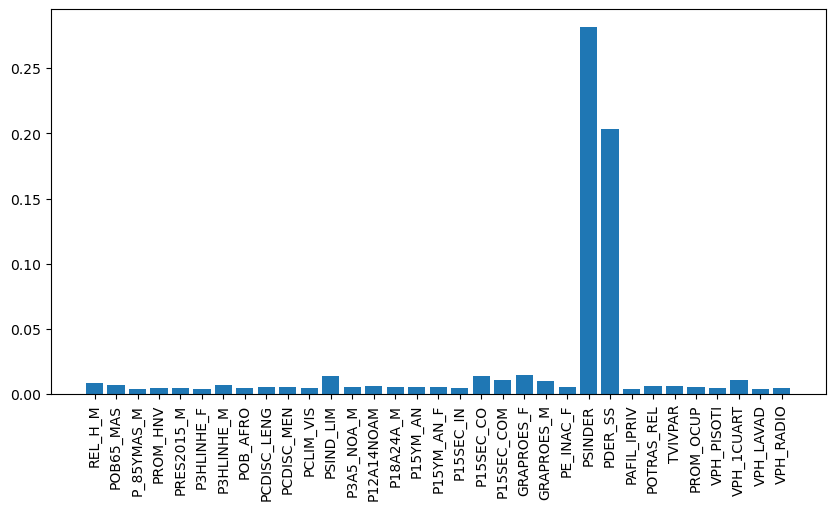

In [29]:
xgb = XGBRegressor(n_estimators=50).fit(X, Y_salud)
selector = SelectFromModel(estimator=xgb, threshold='mean', prefit=True)

selected = selector.get_support()
s_features = names[selected]
selected_importances = xgb.feature_importances_[selected]
sorted_s_features = s_features[np.argsort(selected_importances)[::-1]]

print("Características seleccionadas y ordenadas por importancia:", sorted_s_features)
# Plot the feature scores per feature
plt.figure(figsize=(10, 5))
plt.bar(s_features, selected_importances)
plt.xticks(rotation=90)
plt.show()

*Se busca que seleccionen las 10 características con mayor correlación estadística con `ic_asalud`. Con el  objetivo es capturar los predictores más relevantes para el acceso a la sanidad.*

Características seleccionadas y ordenadas por importancia: ['PSINDER' 'PDER_SS' 'PDER_SEGP' 'POCUPADA_F' 'PEA_F' 'PE_INAC' 'POCUPADA'
 'PEA' 'PE_INAC_F' 'PE_INAC_M']


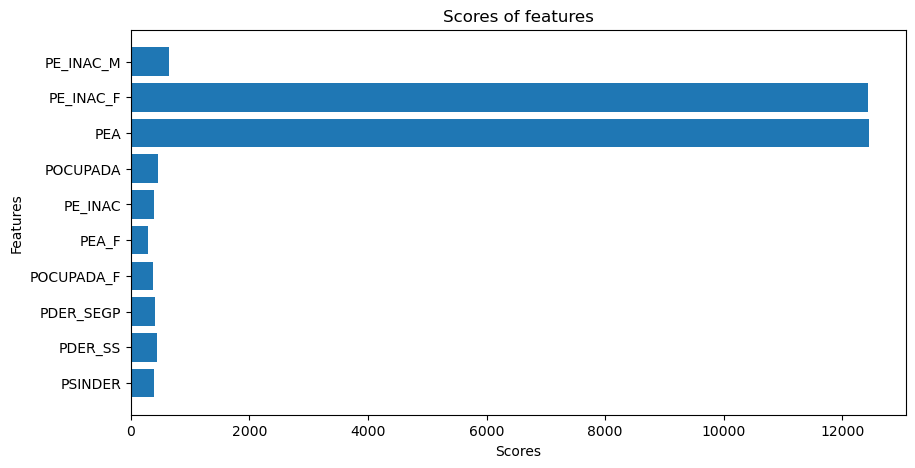

In [30]:
# SelectKbest ICSS

from sklearn.feature_selection import SelectKBest, f_regression

skb = SelectKBest(score_func=f_regression, k=10).fit(X, Y_salud)
selected = skb.get_support()
selected_features = names[selected]
selected_scores = skb.scores_[selected]
selected_features = selected_features[np.argsort(selected_scores)[::-1]]

print("Características seleccionadas y ordenadas por importancia:", selected_features)
plt.figure(figsize=(10, 5))
plt.barh(selected_features, selected_scores)
plt.xlabel('Scores')
plt.ylabel('Features')
plt.title('Scores of features')
plt.show()

# Bases de datos con características escogidas

*Creamos un nuevo dataset `dataI1.csv` con las con las características más importantes para `pobreza_m` y al mismo tiempo se descarga el archivo en el ordenador local*

In [31]:
dataI1 = data[['PRO_OCUP_C', 'PDER_IMSS', 'PROM_OCUP', 'VPH_AUTOM', 'GRAPROES', 'PDER_SS', 'PSINDER', 'P15SEC_CO','VPH_NODREN', 'VPH_PC', 'pobreza_m']]
dataI1.to_csv('dataI1.csv', index=False)

*Hace lo mismo para ic_asalud, almacenándolo en `dataI2.csv`.*

In [32]:
# Variables seleccionadas por indicador pobreza moderada
dataI1 = data[['VPH_HMICRO', 'VPH_PC','PDER_IMSS','VPH_CEL', 'VPH_AUTOM', 'VPH_REFRI', 'pobreza_m']]

# Guardas las variables seleccionadas en un archivo csv
dataI1.to_csv('dataI1.csv', index=False)

#Variables seleccionadas por indicador 
dataI2 = data[['PSINDER', 'PDER_SS', 'PDER_SEGP']]
dataI2.to_csv('dataI2.csv', index=False)